## bt 패키지
### bt 패키지에서는 백테스트의 과정을 다음과 같이 정의한다.

- 데이터의 수집
- 전략의 정의
- 데이터를 이용한 전략의 백테스트
- 결과에 대한 평가
- 데이터의 수집
- 백테스트를 위해서는 먼저 데이터를 준비해야 한다. bt 패키지의 get() 함수는 야후 파이낸스 API를 이용해 수정주가를 다운로드 받을 수 있게 해준다. 물론 기존의 Pandas-datareader 패키지나 크롤링을 통해 데이터를 수집할 수도 있다.

In [1]:
import bt
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib import gridspec
import pandas as pd
import numpy as np
import yfinance as tf
import talib

In [2]:
mpl.rcParams['font.family'] = 'Malgun Gothic' # window
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000

In [39]:
data_list = bt.get("SPY, QQQ, SOXL, TLT", start='2020-01-01').dropna()
data_list.tail()

,spy,qqq,soxl,tlt
Date,,,,
2023-06-26,431.440002,357.679993,22.090000,103.440002
2023-06-27,436.170013,363.829987,24.370001,103.169998
2023-06-28,436.390015,364.540009,23.719999,103.610001
2023-06-29,438.109985,363.809998,23.809999,101.739998
2023-06-30,443.279999,369.420013,24.830000,102.940002


### 전략의 정의
- 두번째로 시뮬레이션 하고자 하는 백테스트가 어떤 것인지를 정의해야 한다. 10개 자산을 동일비중으로 투자하며, 매월 말 리밸런싱 하는 전략을 정의해보도록 하겠다. Strategy() 함수 내에 algos 모듈을 이용해 백테스트 하고자 하는 내용을 입력한다.

## 매월 말 리밸런싱 전략
- 동일비중

In [37]:
# import bt

# 전체 자산 동일비중, 매월 말 리밸런싱
strategy = bt.Strategy("Asset_EW", [
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])

### 먼저 전략의 이름(Asset_EW)을 입력한다.
1. bt.algos.SelectAll() 함수를 통해 모든 데이터를 사용함을 정의한다.
2. bt.algos.WeighEqually() 함수를 통해 동일비중으로 투자할 것을 정의한다.
3. bt.algos.RunMonthly() 함수를 통해 매월말 리밸런싱 함을 정의한다.
4. bt.algos.Rebalance() 함수를 통해 계산된 비중에 따라 리밸런싱 함을 정의한다.
이 외에 algos 모듈을 통해 다양한 백테스트 로직을 정의할 수 있으며, 자세한 내용은 아래 사이트에서 확인할 수 있다.

- https://pmorissette.github.io/bt/bt.html#module-bt.algos

### 전략의 백테스트
앞에서 정의된 내용을 바탕으로 백테스트를 실행한다.

1. 가격 데이터 중 ETF의 시작 시점이 모두 다르므로, dropna() 함수를 통해 NA를 모두 제거하여 시작시점을 동일하게 만든다.
2. Backtest() 함수를 통해 백테스트를 생성할 수 있으며, 앞에서 정의한 백테스트 정의(strategy)와 가격 데이터(data)를 입력한다.
3. run() 함수를 통해 백테스트를 실행하며, 앞에서 생성된 백테스트(backtest)를 입력한다.

In [51]:
# data_bt = data.dropna()

# 백테스트 생성
backtest = bt.Backtest(strategy, data_list)

# 백테스트 실행
result = bt.run(backtest)

In [52]:
result.prices
# 백테스트 결과에서 prices를 입력하면 누적수익률이 데이터프레임 형태로 나타나며, 시작시점을 100으로 환산하여 계산된다.

,Asset_EW
2020-01-01,100.000000
2020-01-02,100.000000
2020-01-03,98.616566
2020-01-06,97.976454
2020-01-07,98.959714
...,...
2023-06-26,167.882752
2023-06-27,173.242795
2023-06-28,172.306271
2023-06-29,171.806197


In [53]:
result.prices.to_returns() # prices에 추가로 to_returns()를 입력하면, 수익률이 계산된다.

,Asset_EW
2020-01-01,NaN
2020-01-02,0.000000
2020-01-03,-0.013834
2020-01-06,-0.006491
2020-01-07,0.010036
...,...
2023-06-26,-0.001955
2023-06-27,0.031927
2023-06-28,-0.005406
2023-06-29,-0.002902


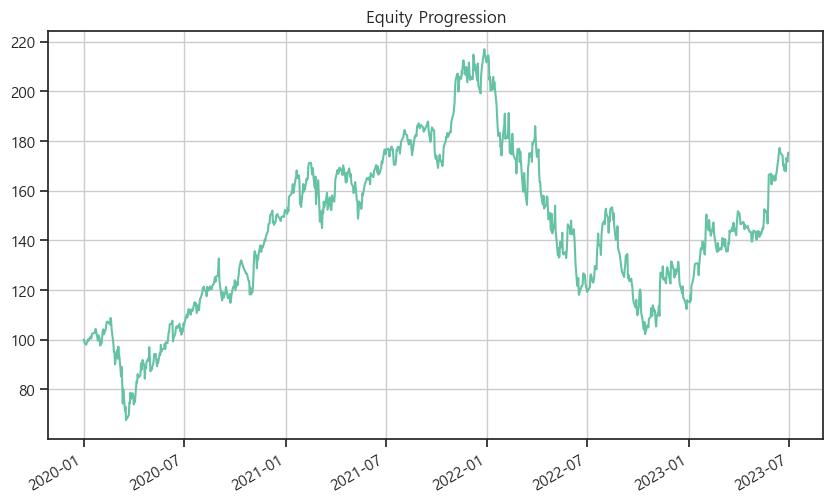

In [54]:
# 누적수익률 그래프

# import matplotlib.pyplot as plt
%matplotlib inline

result.plot(figsize=(10, 6), legend=False)
plt.show()

In [55]:
# 종목별 투자비중
result.get_security_weights().head()

,spy,qqq,soxl,tlt
2020-01-01,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.249896,0.249832,0.249994,0.249964
2020-01-03,0.251483,0.251016,0.239808,0.257374
2020-01-06,0.254092,0.254284,0.233719,0.257585
2020-01-07,0.250860,0.251723,0.243329,0.253771


1. area()를 통해 면적 그래프를 나타내며, 
2. 축의 범위는 0에서 1, 범례(legend)는 제외, 색 구분은 cm.jet을 이용한다.
3. get_legend_handles_labels()를 통해 범례를 받아온다.
4. 좌우 마진을 0으로 둔다.
5. legend() 함수를 통해 범례를 나타내며, 그래프와 색 순서를 맞추기 위해 reversed()를 통해 순서를 바꾼다. 또한 위치는 오른쪽 아래(lower right)의 (1.15, 0) 지점으로 한다.
6. 그림을 나타낸다.
- 매월 말 리밸런싱을 하므로, 대부분의 구간에서 모든 자산에 10%씩 균등하게 투자된다. 이번에는 각종 성과지표를 확인해보도록 하자.

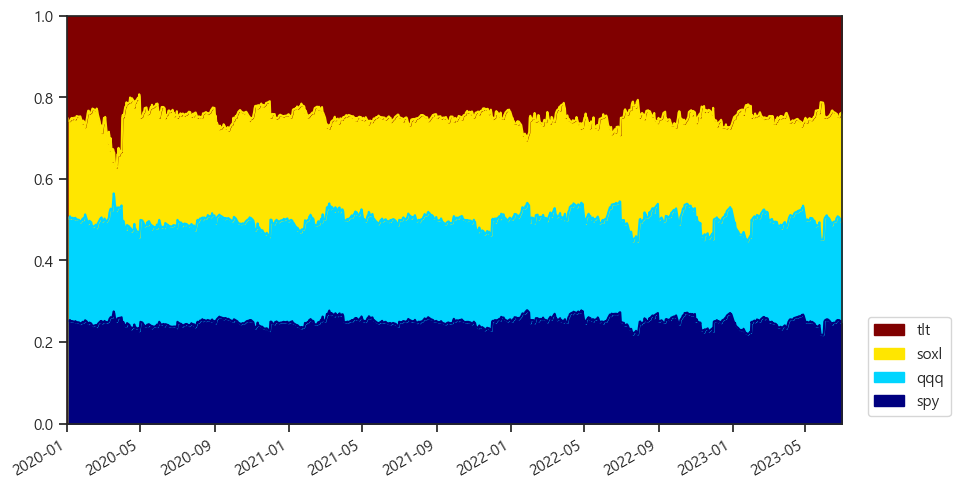

In [56]:
# from matplotlib import cm

ax = result.get_security_weights().plot.area(figsize=(10, 6),
                                             ylim=[0, 1],
                                             legend=False,
                                             colormap=cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles),
           reversed(labels),
           loc='lower right',
           bbox_to_anchor=(1.15, 0))
plt.show()

### display() 메서드를 통해 각종 성과 측정치를 구할 수 있다. 각 지표가 의미하는 바는 다음과 같다.
- Start; 시작일
- End: 종료일
- Risk-free rate: 무위험 수익률
- Total Return: 총 수익률
- Sharpe: 샤프지수 (평균 수익률/변동성)
- Sortino: 소티노지수 (평균 수익률/마이너스 수익률의 변동성)
- CAGR: 연평균 수익률
- Max drawdown: 최대 손실률 (MDD)
- Calmar Ratio: 칼마지수 (수익률/MDD)
- MTD / 3m / 6m / YTD: 금월, 3개월, 6개월, 올해 수익률
- 1Y / 3Y (ann.) / 5Y (ann.) / 10Y (ann.): 1년 / 3년 / 5년 / 10년 기준 연율화 수익률
- Since Incep. (ann): 시작 이후 연율화 수익률
- Mean (ann.): 연평균 수익률
- Vol (ann.): 연평균 변동성
- Skew: 왜도
- Kurt: 첨도
- Best: 최고 수익률
- Worst: 최저 수익률
- Avg. Drawdown: 손실(Drawdown)의 평균
- Avg. Drawdown Days: 손실(Drawdown) 발생 후 회복까지 평균일수
- Avg. Up Month: 상승한 달의 평균 수익률
- Avg. Down Month: 하락한 달의 평균 수익률
- Win Year %: 연도별 양의 수익률을 기록할 확률
- Win 12m %: 12개월 투자했을 시 양의 수익률을 기록할 확률

In [57]:
result.display()

Stat                 Asset_EW
-------------------  ----------
Start                2020-01-01
End                  2023-06-30
Risk-free rate       0.00%

Total Return         75.37%
Daily Sharpe         0.61
Daily Sortino        1.01
CAGR                 17.44%
Max Drawdown         -52.90%
Calmar Ratio         0.33

MTD                  7.87%
3m                   17.49%
6m                   51.84%
YTD                  51.84%
1Y                   45.45%
3Y (ann.)            18.11%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  17.44%

Daily Sharpe         0.61
Daily Sortino        1.01
Daily Mean (ann.)    23.67%
Daily Vol (ann.)     38.90%
Daily Skew           -0.13
Daily Kurt           2.07
Best Day             12.07%
Worst Day            -10.77%

Monthly Sharpe       0.65
Monthly Sortino      1.21
Monthly Mean (ann.)  23.88%
Monthly Vol (ann.)   36.87%
Monthly Skew         -0.06
Monthly Kurt         -0.36
Best Month           21.69%
Worst Month          -19.00%

Y

C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\li

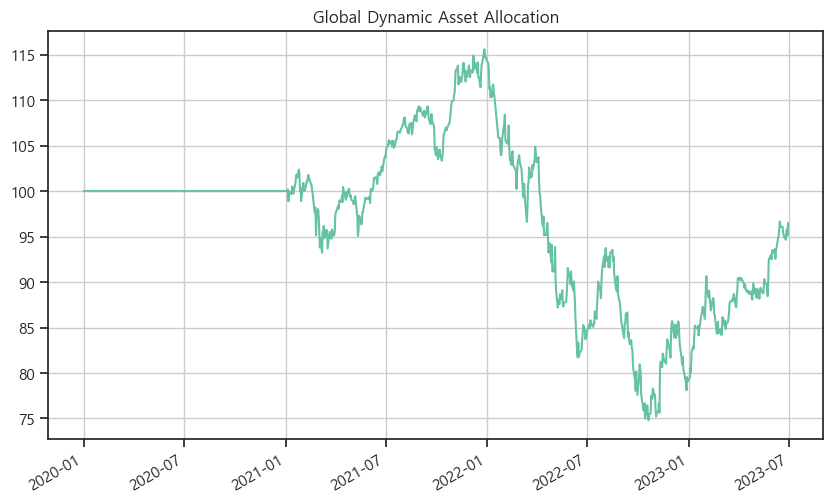

In [58]:
# import bt
# import matplotlib.pyplot as plt
# import pandas as pd


gdaa = bt.Strategy('GDAA', [
    bt.algos.SelectAll(),
    bt.algos.SelectMomentum(n=5, lookback=pd.DateOffset(years=1)),
    bt.algos.WeighERC(lookback=pd.DateOffset(years=1)),
    bt.algos.RunMonthly(),    
    bt.algos.Rebalance()
])

gdaa_backtest = bt.Backtest(gdaa, data_list)
gdaa_result = bt.run(gdaa_backtest)

gdaa_result.plot(figsize=(10, 6),
                 title='Global Dynamic Asset Allocation',
                 legend=False)
plt.show()

In [59]:
gdaa_result.get_security_weights().head()

,soxl,qqq,spy,tlt
2020-01-01,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0


## 평균회귀 전략 백테스트
추세추종 전략은 주가가 동일한 방향으로 지속된다고 보는 반면, 평균회귀 전략은 주가가 평균으로 회귀한다고 보며 이에 베팅한다. 주가가 무한정 한방향으로 지속될 수는 없기에 추세추종 전략과 평균회귀 전략을 잘 조합할 필요가 있다.

## RSI를 이용한 전략
RSI는 일정기간 동안 주가의 상승폭과 하락폭의 크기를 비교해 상승과 하락의 상대적인 강도를 나타낸 지표로써, 일반적으로 
- RSI가 70 이상일 경우 과매수 구간으로써 매도할 때를, 
- 30 이하일 경우 과매도 구간으로써 매수해야 할 때로 여겨진다. 
이에 대한 백테스트를 실행해보도록 하자.

In [1]:
# import talib
# import bt

In [60]:
data = bt.get("SPY", start='2020-01-01')
data_1 = bt.get("TLT", start='2020-01-01')
data_list.tail()
# data.tail(),data_1.tail()

,spy,qqq,soxl,tlt
Date,,,,
2023-06-26,431.440002,357.679993,22.090000,103.440002
2023-06-27,436.170013,363.829987,24.370001,103.169998
2023-06-28,436.390015,364.540009,23.719999,103.610001
2023-06-29,438.109985,363.809998,23.809999,101.739998
2023-06-30,443.279999,369.420013,24.830000,102.940002


### RSI 신호 만들기

1. 먼저 apply() 함수 내부에 RSI()을 이용해 14일 기준 RSI를 구한다. 
2. 그 후 RSI가 70을 초과하면 -1(숏 포지션), 
3. 30 미만이면 1(롱 포지션), 
4. 30과 70 사이면 0(뉴트럴)인 신호를 만든다.

In [19]:
spy_rsi = data.apply(lambda x: talib.RSI(x, 14))

signal = spy_rsi.copy()
signal[spy_rsi > 70] = -1
signal[spy_rsi < 30] = 1
signal[(spy_rsi <= 70) & (spy_rsi >= 30)] = 0
signal[signal.isnull()] = 0

# sox_rsi = data_1.apply(lambda x: talib.RSI(x, 14))

# signal_1 = sox_rsi.copy()
# signal_1[sox_rsi > 70] = -1
# signal_1[sox_rsi < 30] = 1
# signal_1[(sox_rsi <= 70) & (spy_rsi >= 30)] = 0
# signal_1[signal_1.isnull()] = 0

In [27]:
sox_rsi = data_1.apply(lambda x: talib.RSI(x, 14))

signal_1 = sox_rsi.copy()
signal_1[sox_rsi > 70] = -1
signal_1[sox_rsi < 30] = 1
signal_1[(sox_rsi <= 70) & (spy_rsi >= 30)] = 0
signal_1[signal_1.isnull()] = 0

먼저 apply() 함수 내부에 RSI()을 이용해 14일 기준 RSI를 구한다. 그 후 RSI가 70을 초과하면 -1(숏 포지션), 30 미만이면 1(롱 포지션), 30과 70 사이면 0(뉴트럴)인 신호를 만든다.

In [5]:
# import matplotlib.pyplot as plt
# from matplotlib import gridspec

C:\Users\com\AppData\Local\Temp\ipykernel_3196\2073001498.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])


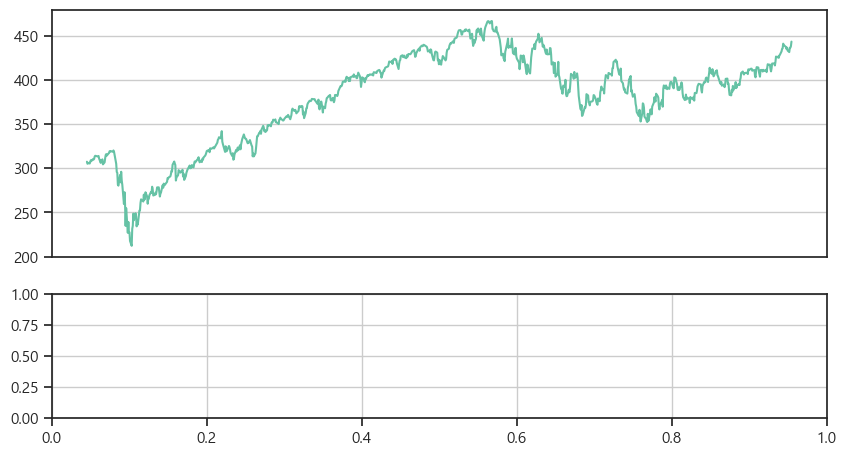

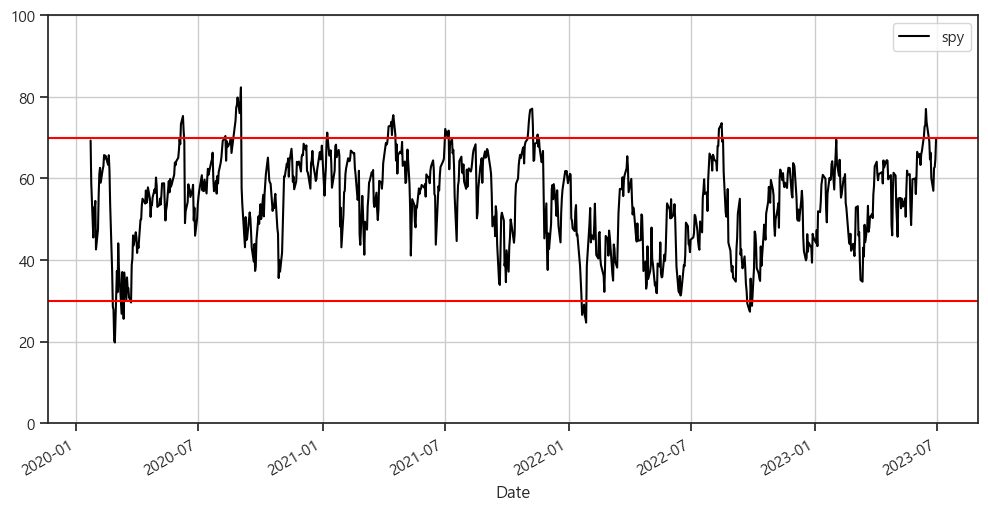

In [68]:
fig = plt.subplots(figsize=(10, 6), sharex=True)
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax1 = data['spy'].plot()
ax1.set_xlabel('')
ax1.axes.xaxis.set_ticks([])

ax2 = plt.subplot(gs[1])
ax2 = spy_rsi.plot(color='black', ylim=[0, 100])
ax2 = plt.axhline(y=30, color='red', linestyle='-')
ax2 = plt.axhline(y=70, color='red', linestyle='-')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
#########################################################
# # fig = plt.subplots(figsize=(10, 6), sharex=True)
# # gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])

# # ax1 = plt.subplot(gs[0])
# # ax1 = data_1.plot()
# # ax1.set_xlabel('')
# # ax1.axes.xaxis.set_ticks([])

# ax4 = plt.subplot(gs[1])
# ax4 = sox_rsi.plot(color='black', ylim=[0, 100])
# ax4 = plt.axhline(y=30, color='red', linestyle='-')
# ax4 = plt.axhline(y=70, color='red', linestyle='-')

# # plt.subplots_adjust(wspace=0, hspace=0)
# plt.show()

C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


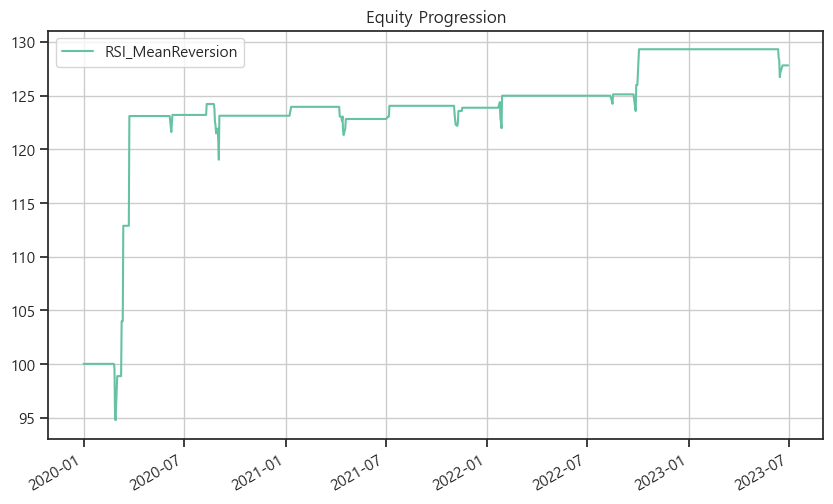

In [31]:
strategy = bt.Strategy('RSI_MeanReversion',
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


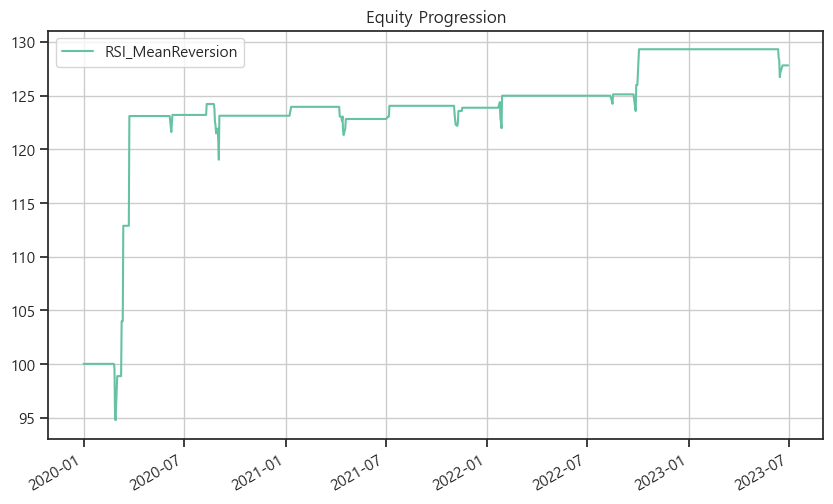

In [33]:
strategy = bt.Strategy('RSI_MeanReversion',
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

RSI를 이용하여 트레이딩을 할 경우 장기간으로 큰 손실없이 잘 작동하지만, 과매수 혹은 과매도로 인한 투자 신호가 나타나는 경우가 드물어 누적수익률 자체도 그렇게 높지 않다. 반면 2020년의 경우 추세추종 전략과는 반대로 3월 급락장에서 과매도 신호로 인해 매수를 함으로써, 반등으로 인해 상당한 수익을 거두기도 한다. 이처럼 추세추종과 평균회귀는 서로 상반되는 특징이 있으므로, 이를 잘 조합하면 훨씬 안정적인 수익을 거둘 수 있는 트레이딩 전략을 개발할 수도 있다.

성과 중 주요 지표를 확인해보도록 하자.

In [69]:
result.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,Asset_EW
total_return,0.753744
cagr,0.174449
daily_vol,0.388965
max_drawdown,-0.529004
calmar,0.32977
daily_sharpe,0.608449


## 볼린저 밴드를 이용한 전략
이번에는 볼린저 밴드를 이용한 평균회귀 전략을 백테스트 해보도록 하겠다. 볼린저밴드는 이동평균선을 중심으로 일정 표준편차를 상한선과 하한선으로 설정한 밴드다. 주가가 정규분포를 따른다면 주가의 움직임은 상한선과 하한선으로 구성된 밴드 내에서만 움직일 확률이 높다. 따라서 주가가 상한선 위에 있다는 것은 과매수 상태이므로 하락할 가능성이 높으르로 숏 포지션을, 하단선 아래에 있다는 것은 과매도 상태이므로 상승할 가능성이 높으므로 롱 포지션을 취한다.

In [101]:
data_1 = bt.get('SPY',start='2010-01-01')
# data_1.tail()
data_list.tail()
# data_1.tail()

[*********************100%***********************]  1 of 1 completed


,spy
Date,
2023-06-26,431.440002
2023-06-27,436.170013
2023-06-28,436.390015
2023-06-29,438.109985
2023-06-30,443.279999


In [87]:
upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data_list['spy'],
                                             nbdevup=2,
                                             nbdevdn=2,
                                             timeperiod=20)

bb = pd.concat([upper_2sd, mid_2sd, lower_2sd, data_list['spy']], axis=1)
bb.columns = ['Upper Band', 'Mid Band', 'Lower Band','spy']

# upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data_list['tlt'],
#                                              nbdevup=2,
#                                              nbdevdn=2,
#                                              timeperiod=20)

# bb_1 = pd.concat([upper_2sd, mid_2sd, lower_2sd, data_list['tlt']], axis=1)
# bb_1.columns = ['Upper Band', 'Mid Band', 'Lower Band','spy']

<Axes: xlabel='Date'>

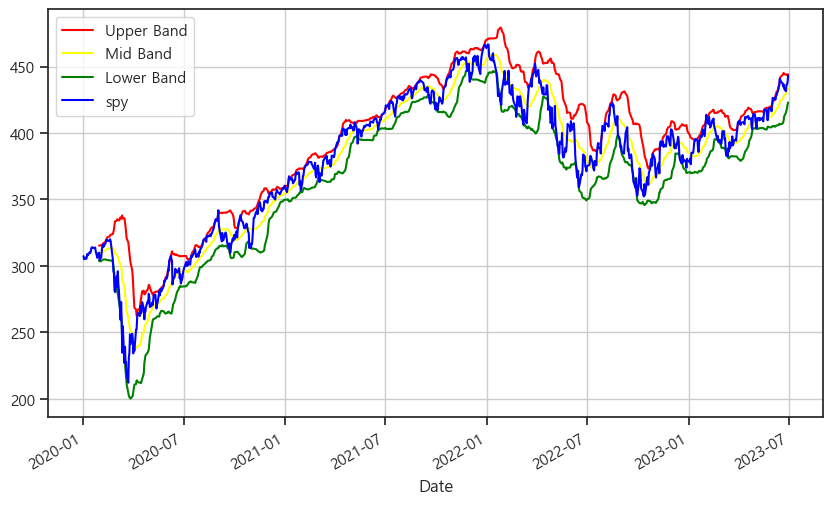

In [88]:
bb.plot(figsize=(10,6),
       color = {
       'Upper Band' : 'red',
       'Mid Band' : 'yellow',
       'Lower Band' : 'Green',
       'spy':'blue'})

BBANDS() 함수를 이용해 20일 기준 2 표준편차에 해당하는 볼린저 밴드의 상, 중, 하단 값을 계산한 후 하나의 데이터프레임으로 묶어준다.

In [107]:
import numpy as np

signal = data_1.copy()
signal['spy'] = np.nan

signal[bb['spy'] > bb['Upper Band']] = -1
signal[bb['spy'] < bb['Lower Band']] = 1
signal[signal.isnull()] = 0

ValueError: Item wrong length 880 instead of 3396!

주가가 상한선 위에 있을 경우 -1(숏 포지션), 주가가 하한선 아래에 있을 경우 1(롱 포지션), 그 외의 경우 0(뉴트럴)의 신호를 만둔다. 해당 신호를 바탕으로 백테스트를 실행해보자.

C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


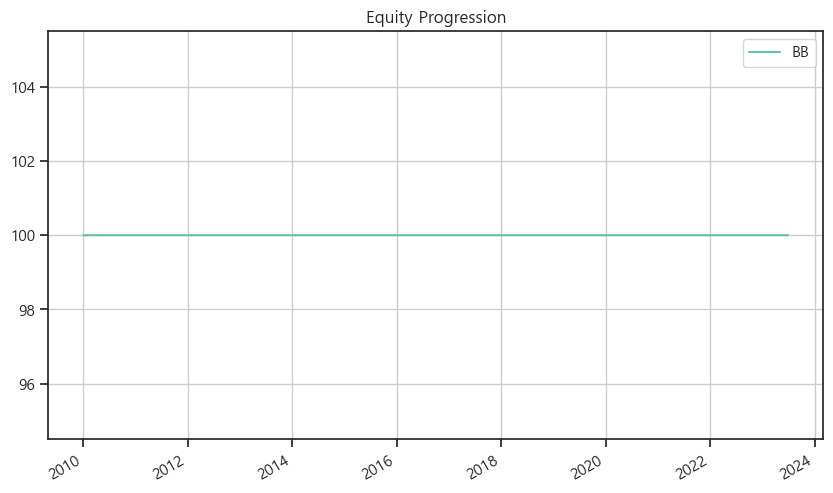

In [108]:
strategy = bt.Strategy('BB',
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data_1)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

RSI와 마찬가지로 볼린저밴드를 이용한 평균회귀 트레이딩을 할 경우에도 장기간으로 큰 손실없이 잘 작동한다. 주요 성과 지표는 다음과 같다.

In [109]:
result.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,BB
total_return,0.0
cagr,0.0
daily_vol,0.0
max_drawdown,0.0
calmar,NaN
daily_sharpe,NaN


## bt 패키지의 함수
## 마지막으로 bt 패키지의 함수들을 정리해보도록 하겠다.

## 유니버스 선택

- bt.algos.SelectAll(): 모든 종목 선택
- bt.algos.SelectHasData(): 일정 갯수 이상의 데이터가 있는 종목 선택
- bt.algos.SelectMomentum(): 모멘텀 상위 종목 선택, bt.algos.SelectAll()을 먼저 불러와야 함
- bt.algos.SelectWhere(): 입력값이 True 일때만 투자

### 비중 선택

- bt.algos.WeighEqually(): 동일 비중
- bt.algos.WeighSpecified(): 비중 직접 입력. 리밸런싱 마다 동일한 값 적용.
- bt.algos.WeighTarget(signal): 비중 직접 입력. 리밸런싱 마다 입력한 값 적용.
- bt.algos.WeighERC(): 위험균형 전략
- bt.algos.WeighInvVol(): 역변동성 전략
- bt.algos.WeighMeanVar(): 최대샤프지수 전략

### 리밸런싱 시점

- bt.algos.RunOnce(): 처음 한번만 리밸런싱
- bt.algos.RunDaily(): 매일 리밸런싱
- bt.algos.RunMonthly(): 매월 리밸런싱
- bt.algos.RunQuarterly(): 매분기 리밸런싱
- bt.algos.RunWeekly(): 매주 리밸런싱
- bt.algos.RunYearly(): 매년 리밸런싱

### 리밸런싱 방법

- bt.algos.Rebalance(): 선택한 시점과 비중에 따라 리밸런싱
- bt.algos.RebalanceOverTime(): n일에 걸쳐 리밸런싱

### 기타 함수들

- plot_weights(): 투자 비중 출력
- get_security_weights(): 투자 비중을 데이터프레임 형태로 반환
- prices(): 누적수익률을 데이터프레임 형태로 구하기
- prices.rebase(): 특정 시점부터 다시 100으로 환산
- prices.to_returns(): 수익률 계산
- display(): 성과 측정치
- display_monthly_returns(): 월간 수익률 구하기
- turnover(): 회전율 구하기

{note}
위에서 백테스트한 추세추종과 평균회귀 전략의 경우 신호가 발생하면 해당일 종가에 포지션을 취한다고 가정했다. 그러나 현실에서는 종가 직전까지 발생한 신호를 바탕으로 종가에 매매를 하거나 종가로 계산된 신호를 바탕으로 다음날 시가에 매매를 해야하므로, 백테스트의 수익률과 실제 수익률은 상당히 차이가 있을 수 있다. 또한 매매수수료와 시장충격으로 인해 백테스트의 수익률과 실제 수익률간 차이가 발생할 수도 있다.
{note}
크롤링으로 수집한 데이터로 개별 주식에 대한 백테스트를 하기에는 생존 편향, 소급 편향 등의 문제가 있으며, 난이도 역시 매우 높다. 두물머리에서 제공하는 '올라떼' 사이트에서는 전 세계 주식을 대상으로 양질의 데이터를 통한 각종 팩터 모형에 대한 백테스트를 클릭만으로 수행할 수 있으니 이를 참조하기 바란다.

## 추세추종 전략 백테스트
추세추종이란 주가가 동일한 방향으로 지속될 것이라는데 베팅하는 것이다. 추세추종, 혹은 모멘텀 전략은 월스트리트에서 가장 오래된 투자전략 중 하나로써, 무려 1838년에 출간된 책에도 설명될 만큼 역사가 길고, 현재에도 가장 많이 사용되는 전략 중 하나이다.

## 마켓 타이밍 전략
대표적인 추세추종 전략인 이동평균선을 이용한 트레이딩의 백테스트를 진행해보도록 하겠다. 메브 파버(Meb Faber)는 본인의 논문을 통해, 시점 선택(Market Timing) 전략을 사용할 경우 단순히 매수 후 보유하는 것 대비 극심한 하락장에서 낙폭을 줄일 수 있으며, 이로 인해 위험 대비 수익률을 올릴 수 있다고 설명하였다. 논문에서 말하는 시점 선택의 투자 규칙은 다음과 같다.

- 주가 > 10개월이동평균 = 매수
- 주가 < 10개월이동평균 = 매도 및 현금보유
즉 주가가 10개월 이동평균 보다 위에 있다는 것은 상승추세를 의미하므로 매수 포지션을, 10개월 이동평균 보다 아래에 있다는 것을 하락추세를 의미하므로 현금 보유를 통해 하락 방어를 하고자 한다. 먼저 해당 규칙을 미국 S&P 500를 추종하는 SPY ETF에 적용하는 예제를 살펴보겠다.

In [1]:
# import talib
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import numpy as np
# import pandas as pd
# import bt

In [6]:
# mpl.rcParams['font.family'] = 'Malgun Gothic' # window
# plt.rcParams["axes.grid"] = True
# plt.rcParams["figure.figsize"] = (12,6)
# plt.rcParams["axes.formatter.useoffset"] = False
# plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams["axes.formatter.limits"] = -10000, 10000

### 데이터 가져오기

In [113]:
data = bt.get('SPY', start='2010-01-01')
data.tail()

,spy
Date,
2023-06-26,431.440002
2023-06-27,436.170013
2023-06-28,436.390015
2023-06-29,438.109985
2023-06-30,443.279999


먼저 apply() 함수 내부에 SMA()을 이용해 200일(10개월) 이동평균을 구한다.

In [5]:
sma = data.apply(lambda x: talib.SMA(x, 200))

In [7]:
# import bt

bt_sma = bt.Strategy('Timing', [
    bt.algos.SelectWhere(data > sma),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

bt_sma_backtest = bt.Backtest(bt_sma, data)

bt.algos.SelectWhere()는 입력값이 True 일때만 투자를 하도록 정의한다. 즉, ETF 가격에 해당하는 data가 이동평균에 해당하는 sma 보다 클 때에만 투자를 한다. 나머지는 위에서 살펴본 것들과 동일한다.

In [9]:
def buy_and_hold(data, name):

    # 벤치마크 전략 생성(Buy & Hold Strategy)
    bt_strategy = bt.Strategy(name, [        
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.RunOnce(),
        bt.algos.Rebalance()
    ])
    # Return the backtest
    return bt.Backtest(bt_strategy, data)


# 벤치마크 전략 백테스트
stock = buy_and_hold(data[['spy']], name='stock')

# 두개 백테스트 동시에 실행
bt_sma_result = bt.run(bt_sma_backtest, stock)

- buy_and_hold() 함수를 통해 단순 매수 후 보유의 경우를 정의한다. 
- bt.algos.RunOnce()는 리밸런싱이 없이 처음 상태가 그대로 유지되는 것이다.
- SPY의 매수 후 보유 전략을 생성한다.
- 앞에서 생성된 추세추종 전략과, 매수 후 보유의 백테스트를 동시에 실행한다.

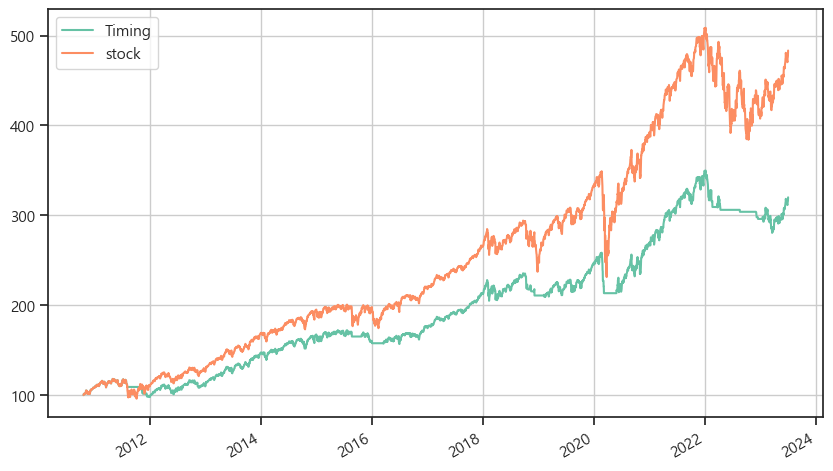

In [12]:
bt_sma_result.prices.iloc[201:, ].rebase().plot(figsize=(10, 6))
plt.show()

추세추종 전략의 경우 이동평균 계산을 위해 처음 200 일간은 투자가 되지 않으므로 매수 후 보유 전략과 시작 시점이 일치하지 않는다. 따라서 200일이 지난 후부터의 데이터를 선택한다. 그 후 rebase() 함수를 이용해 데이터의 시작시점을 다시 100으로 만든다.

추세추종 전략을 사용할 경우 2000년 IT 버블이나 2008년 금융위기시 하락폭이 제한된다. 즉 하락추세가 시작되면 주식을 모두 매도하여, 추가적인 하락을 방어한다.

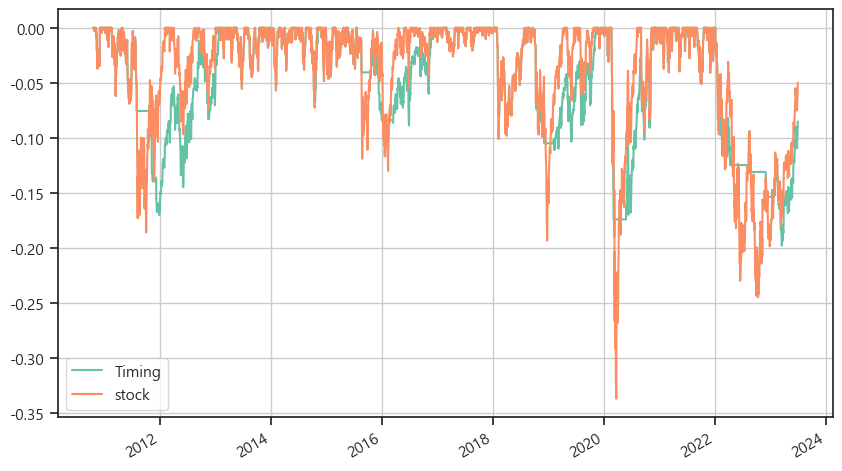

In [13]:
bt_sma_result.prices.iloc[201:, ].rebase().to_drawdown_series().plot(
    figsize=(10, 6))
plt.show()

to_drawdown_series() 함수는 낙폭(drawdown)을 계산한다. 앞서 언급한 것 처럼 추세추종 전략을 사용할 경우 하락 방어가 우수하다. 반면 코로나19 사태 직후인 2020년 3월의 경우 추세추종 전략은 추세가 깨져 투자를 하지 않지만, 주식 시장이 급반등 함에 따라 매수 후 보유 전략의 상승분을 따라가지 못하기도 하였다.

In [14]:
bt_sma_result.stats.loc[[
    'total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe', 'daily_sortino'
]]

,Timing,stock
total_return,2.158033,4.049011
cagr,0.089006,0.127563
daily_vol,0.113801,0.175038
max_drawdown,-0.198056,-0.337168
calmar,0.4494,0.378337
daily_sharpe,0.807069,0.774443
daily_sortino,1.203774,1.199375


수익률 자체는 단순 보유전략(stock)이 높지만 변동성이나 MDD와 같은 위험지표는 마켓 타이밍 전략(Timing)이 훨씬 낮다. 결과적으로 위험을 고려한 성과 지표는 마켓 타이밍 전략이 더 우수하다.

## 파라미터 최적화
과연 200일(10개월) 이동평균을 사용하는 것이 최적일까? 혹은 다른 값을 사용했을 때 수익률이 더 좋을수 있지 않을까? 이러한 질문은 트레이더들이 항상 하는 질문이다. '200일'과 같이 우리가 임의로 정하는 변수를 파라미터(parameter)라 하며, 성과가 최대화 되는 파라미터를 찾는 것을 파라미터 최적화라고 한다. 트레이딩에서 이러한 파라미터 최적화는 매우 중요한 작업이다. 앞선 마켓 타이밍 전략에서 이동평균을 계산할 때 사용하는 일수를 변경해가며 수익률을 확인해보도록 하자.

In [17]:
# import talib
# import bt

def timing(data, n):

    sma = data.apply(lambda x: talib.SMA(x, n))
    stragety = bt.Strategy(n, [
        bt.algos.SelectWhere(data > sma),        
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ])

    backtest = bt.Backtest(stragety, data)

    return (backtest)

n_20 = timing(data, 20)
n_60 = timing(data, 60)
n_100 = timing(data, 100)
n_150 = timing(data, 150)
n_200 = timing(data, 200)
n_250 = timing(data, 250)

result = bt.run(n_20, n_60, n_100, n_150, n_200, n_250)

1. 이동평균을 계산한 후, 백테스트를 생성하는 부분을 timing() 함수로 작성한다.
2. 20일부터 250일까지 이동평균을 이용한 마켓타이밍 모델의 백테스트를 생성한다.
3. 모든 백테스트를 한번에 실행한다.

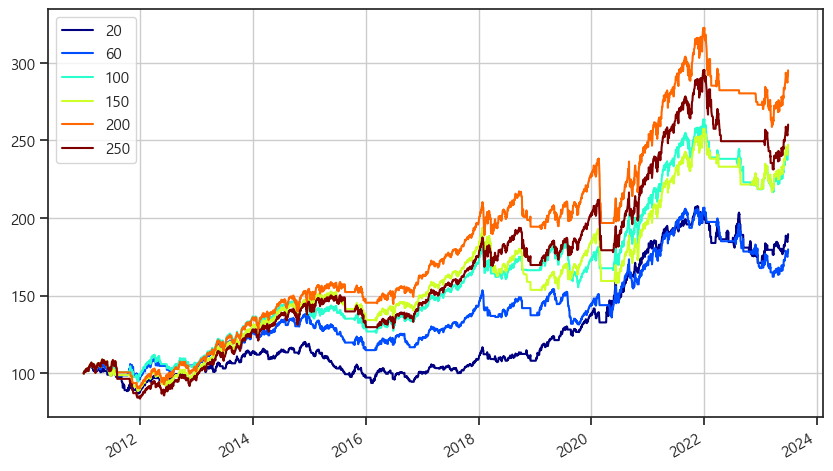

In [18]:
# from matplotlib import cm

result.prices[250:].rebase().plot(figsize=(10, 6), colormap=cm.jet)
plt.show()

누적수익률을 확인해보면 단기 보다는 장기 이동평균을 사용할 수록 우수한 성과를 기록한다. 그러나 예를 들어 250일 이동평균이 최고의 수익률을 기록한다고 이것이 최적의 파라미터라고 말하기는 힘들다. 장기 이동평균을 사용하는 것이 단기 이동평균을 사용하는 것보다 성과가 좋은 이유는, 장기 이동평균이 장기적인 추세를 더 잘 반영하기 때문일 수 있다. 그러나 같은 장기 이동평균에서도 250일이 200일 보다 우수한 것은 단순히 우연의 결과일 수 있으며, 백테스트 기간을 다르게 하면 전혀 다른 결과가 나타날 수도 있다.

백테스트 기간에서 최적화된 파라미터가 향후에도 최고의 수익률을 기록할 것이라는 생각은 위험하다. 백테스트에서는 엄청나게 우수한 성과를 보였던 전략을 찾아 용기있게 실제 투자에 나섰다가 과최적화의 저주에 빠져 실망스러운 수익률로 이어지는 경우도 종종 목격한다. 따라서 모델에 사용되는 파라미터의 갯수는 최대한 작게, 그리고 인샘플(in-sample) 뿐만 아니라 아웃오브샘플(out-of-sample) 테스트에서도 뛰어난 성과를 보이는 파라미터를 택하는 것이 좋다.

## 롱숏 전략
지금까지는 주가가 이동평균선 위에 있을 때 매수하며 그렇지 않으면 현금을 보유하는 '롱온리(Long-Only)' 전략에 대한 백테스트를 실시했다. 그러나 추세추종 전략은 상승추세에 대한 베팅뿐만 아니라 공매도, 인버스 ETF 혹은 선물매도 포지션을 통해 하락추세에도 베팅할 수 있다.

흔히 단기 이동평균선이 중장기 이동평균선을 뚫고 올라가는 골든크로스의 경우 상승추세에 대한 신호를, 반대로 뚫고 내려가는 데드크로스의 경우 하락추세에 대한 신호를 나타낸다. 과연 이러한 신호를 이용해 트레이딩 했을 때 성과가 어떤지 살펴보도록 하자.

In [19]:
# import talib

# data = price[['SPY']]
SMA_200 = data.apply(lambda x: talib.SMA(x, 200))
SMA_60 = data.apply(lambda x: talib.SMA(x, 60))

# stock_data['SMA_20'] = talib.SMA(stock_data['Close'],20)
# stock_data['SMA_60'] = talib.SMA(stock_data['Close'],60)
# stock_data['SMA_120'] = talib.SMA(stock_data['Close'],120)

먼저 장기추세에 해당하는 200일 지수 이동평균과 단기추세에 해당하는 60일 지수 이동평균을 구한다.

In [20]:
signal = SMA_200.copy()
signal[SMA_60 >= SMA_200] = 1
signal[SMA_60 < SMA_200] = -1
signal[signal.isnull()] = 0

만일 60일 이동평균이 200일 이동평균보다 위에 있을 경우(골든크로스) 100% 투자 즉 매수를 하며, 반대의 경우(데드크로스) -100% 투자 즉 매도를 한다. 이동평균을 계산하기 위한 처음 200일 부분은 데이터가 없으므로 포지션을 0으로 둔다.

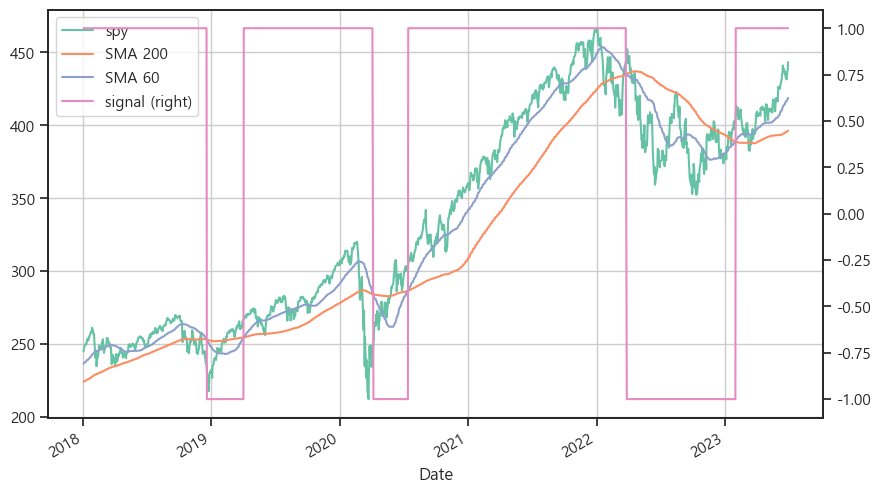

In [21]:
# import matplotlib.pyplot as plt

bind = pd.concat([data, SMA_200, SMA_60, signal], axis=1)
bind.columns = ['spy', 'SMA 200', 'SMA 60', 'signal']
bind.loc['2018':].plot(figsize=(10, 6), secondary_y=['signal'])
plt.show()

2018년 이후부터 주가와 각 이동평균선, 신호를 그림으로 나타내보면 단기 이동평균선(SMA 60)이 장기 이동평균선(SMA 200) 위에 있을 경우에는 매수(1), 그렇지 않을 때는 매도(-1)를 하는 것이 확인된다. 이제 해당 전략의 백테스트를 실행해보자.

C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


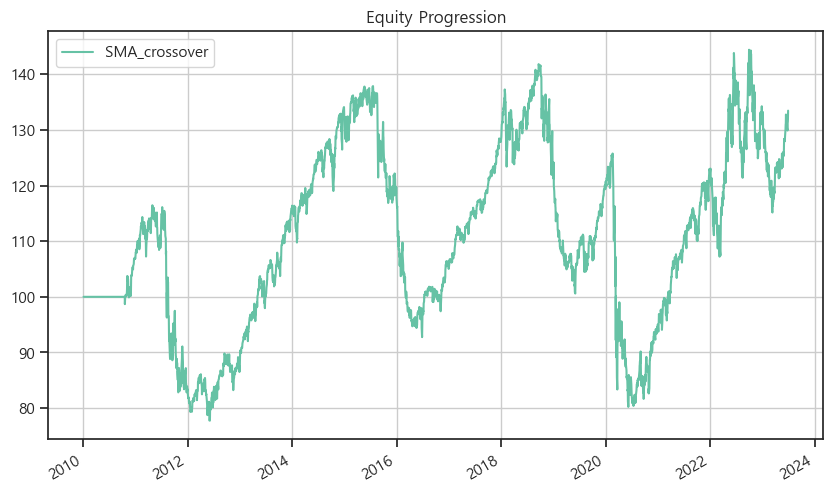

In [22]:
# import bt

strategy = bt.Strategy(
    'SMA_crossover',
    [bt.algos.SelectAll(),
     bt.algos.WeighTarget(signal),
     bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

bt.algos.WeighTarget() 함수 내에 각 시점별 비중을 입력하면, 해당 시점과 비중에 맞춰 리밸런싱이 실시된다. 이를 통해 해당 패키지에서 함수 형태로 제공하지 않는 매우 복잡한 전략의 백테스트도 시기별 비중을 직접 계산해 얼마든지 실행할 수 있다.

결과를 살펴보면 장기간 동안 우상향을 하지만 2011년, 2015~16년, 2020년 등에는 엄청난 낙폭을 기록하기도 했다. 월별 및 연도별 수익률을 확인해보자.

In [23]:
result.display_monthly_returns()

  Year     Jan    Feb     Mar    Apr    May    Jun    Jul     Aug    Sep     Oct    Nov    Dec     YTD
------  ------  -----  ------  -----  -----  -----  -----  ------  -----  ------  -----  -----  ------
  2010    0      0       0      0      0      0      0       0      0       0.18  -0      6.69    6.87
  2011    2.33   3.47    0.01   2.9   -1.12  -1.69  -2     -19.94   6.72  -10.49  -0.34  -1.31  -21.92
  2012   -4.91   4.34    3.22  -0.67  -6.01   4.06   1.18    2.51   2.53   -1.82   0.57   0.89    5.41
  2013    5.12   1.28    3.8    1.92   2.36  -1.33   5.17   -3      3.16    4.63   2.96   2.59   32.31
  2014   -3.52   4.55    0.83   0.7    2.32   2.06  -1.34    3.95  -1.38    2.35   2.75  -0.25   13.46
  2015   -2.96   5.62   -1.57   0.98   1.29  -2.03   2.26   -6.09   0.56   -7.99  -0.47  -0.27  -10.85
  2016  -11.89  -0.18   -6.42  -1.54   1.7    0.35   3.65    0.12   0.01   -1.73   3.68   2.03  -10.79
  2017    1.79   3.93    0.12   0.99   1.41   0.64   2.06    0.29   2.01 

display_monthly_returns() 메서드를 통해 월단위 및 연단위 수익률을 확인할 수 있다. 2020년에는 코로나 이후 주가가 급등했음에도 불구하고, 롱숏 전략은 -20.55%의 큰 손실을 기록하였다. 왜 이런 결과가 나왔는지 해당 구간을 자세히 살펴보도록 하자.

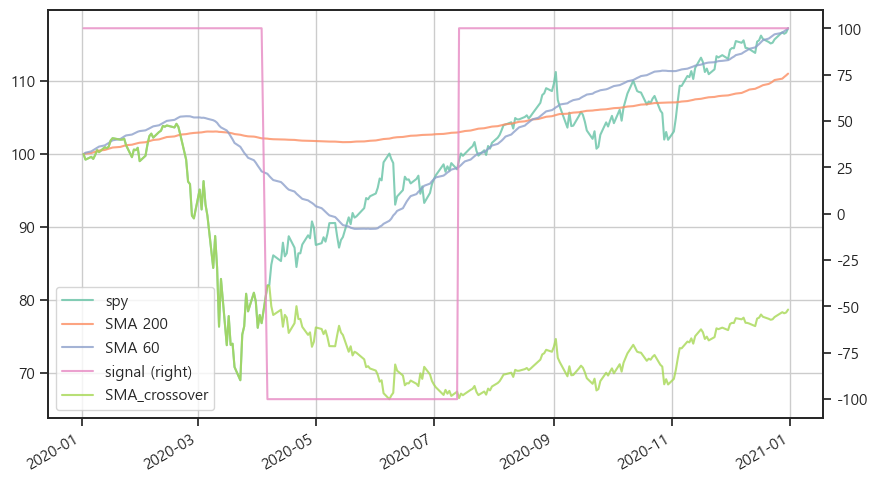

In [24]:
pd.concat([bind, result.prices],
          axis=1).loc['2020'].rebase().plot(figsize=(10, 6),
                                            secondary_y=['signal'],
                                            alpha=0.8)
plt.show()

코로나 사태로 인해 2020년 3월부터 미국 주식(SPY)은 급격하게 하락하기 시작했으며, 3월 중순에는 60일 이동평균선이 200일 이동평균선을 하회함에 따라 숏 신호가 발생하였다. 그러나 공교롭게도 해당 시점부터 시장은 바닥을 다지고 엄청난 상승을 보였으며, 전략(SMA_crossover)에서는 숏 포지션을 취하고 있는 만큼 손실이 발생하기 시작한다. 6월이 되서야 다시 골든크로스가 발생하여 롱 포지션으로 전환하였지만, 불과 3달동안 복구할 수 없을 정도의 손실을 입게 되었다. 실제로 추세추종 전략을 사용하는 많은 펀드들이 2020년 3월부터 6월까지 막대한 손실을 입었다. 2020년 1~3월에는 롱 포지션에서 손실을 입고, 3월부터는 숏 포지션에서 손실을 입어 양방향에서 모두 손실을 입은 것이다.

만일 롱온리 전략을 택했다면 3월부터 6월까지 단순히 수익을 얻지 못한것에 그쳤겠지만, 숏 포지션으로 인해 손실이 배가 된 것이다. 이처럼 숏 베팅은 하락 시장에서도 돈을 벌 수 있게 해주지만, 예상치 못한 급반등이 나올 경우 손실을 입히는 양날의 검이 되기도 한다. 이를 방지하기 위해 트레이딩에서는 다양한 신호의 결합, 손실제한(스탑로스, 로스컷) 등을 추가하기도 한다.